In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_data_loaders(train_dir, val_dir, test_dir, batch_size=32):
    # Define the image transformations with optional adjustments
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.Resize((256, 256)),  # Experiment with 256x256
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load datasets using ImageFolder
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, train_dataset.classes, len(train_dataset.classes)

# Example usage:
if __name__ == "__main__":
    train_loader, val_loader, test_loader, class_names, num_classes = get_data_loaders(
        'data/train', 'data/validation', 'data/test'
    )
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {class_names}")


Number of classes: 9
Classes: ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']


Using device: cuda


C:\Users\Acer\AppData\Local\Temp\ipykernel_161836\2854400053.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(latest_checkpoint))


Model loaded from model_epoch_12.pth.
Resuming training from epoch 13.


100%|██████████| 1830/1830 [18:00<00:00,  1.69it/s]


Epoch [13/20], Loss: 0.0729
Epoch [13/20], Train Loss: 0.0729, Validation Loss: 0.0807, Validation Accuracy: 97.23%


100%|██████████| 1830/1830 [14:42<00:00,  2.07it/s]


Epoch [14/20], Loss: 0.0674
Model saved after epoch 14.
Epoch [14/20], Train Loss: 0.0674, Validation Loss: 0.0849, Validation Accuracy: 97.20%


100%|██████████| 1830/1830 [15:51<00:00,  1.92it/s]


Epoch [15/20], Loss: 0.0610
Epoch [15/20], Train Loss: 0.0610, Validation Loss: 0.0698, Validation Accuracy: 97.68%


100%|██████████| 1830/1830 [15:37<00:00,  1.95it/s]


Epoch [16/20], Loss: 0.0566
Model saved after epoch 16.
Epoch [16/20], Train Loss: 0.0566, Validation Loss: 0.0692, Validation Accuracy: 97.71%


100%|██████████| 1830/1830 [14:34<00:00,  2.09it/s]


Epoch [17/20], Loss: 0.0540
Epoch [17/20], Train Loss: 0.0540, Validation Loss: 0.0709, Validation Accuracy: 97.73%


100%|██████████| 1830/1830 [14:43<00:00,  2.07it/s]


Epoch [18/20], Loss: 0.0542
Model saved after epoch 18.
Epoch [18/20], Train Loss: 0.0542, Validation Loss: 0.0754, Validation Accuracy: 97.58%


100%|██████████| 1830/1830 [15:54<00:00,  1.92it/s]


Epoch [19/20], Loss: 0.0499
Epoch [19/20], Train Loss: 0.0499, Validation Loss: 0.0714, Validation Accuracy: 97.68%


100%|██████████| 1830/1830 [16:35<00:00,  1.84it/s]


Epoch [20/20], Loss: 0.0461
Model saved after epoch 20.
Epoch [20/20], Train Loss: 0.0461, Validation Loss: 0.0731, Validation Accuracy: 97.63%
Final model saved as final_model.pth


ValueError: x and y must have same first dimension, but have shapes (20,) and (8,)

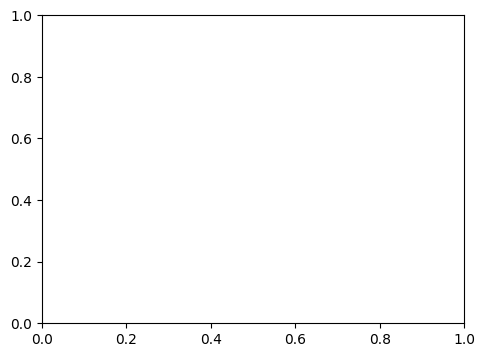

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import resnet101, ResNet101_Weights
from tqdm import tqdm  # For progress bar
from data_preprocessing import get_data_loaders  # Import your data loader function
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths to your dataset
train_dir = "data//train"
val_dir = "data//validation"
test_dir = "data//test"

# Load data loaders
train_loader, val_loader, test_loader, class_names, num_classes = get_data_loaders(train_dir, val_dir, test_dir)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Check which device is being used

# Load the pretrained ResNet50 model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

# Modify the final layer for your number of classes
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to the appropriate device
model.to(device)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Check for the latest checkpoint and set resume_epoch
resume_epoch = 0
latest_checkpoint = 'model_epoch_12.pth'  # Modify if necessary, or use a variable to store the latest checkpoint dynamically

if os.path.exists(latest_checkpoint):
    model.load_state_dict(torch.load(latest_checkpoint))
    print(f"Model loaded from {latest_checkpoint}.")
    resume_epoch = int(latest_checkpoint.split('_')[-1].split('.')[0])
    print(f"Resuming training from epoch {resume_epoch + 1}.")

# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 5
epochs_without_improvement = 0

# Track losses and accuracy for visualization
train_losses, val_losses = [], []
val_accuracies = []

# Training loop starting from resume_epoch
num_epochs = 20  # Adjust as necessary
for epoch in range(resume_epoch, num_epochs):  # Start from resume_epoch
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
    
    # Save model every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
        print(f"Model saved after epoch {epoch + 1}.")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print average validation loss and accuracy for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break  # Exit the training loop

# Save the final model
torch.save(model.state_dict(), 'final_model.pth')
print("Final model saved as final_model.pth")

# Plotting the results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

all_preds=[]
all_labels=[]

# Testing loop
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))


In [ ]:
# Plot the training and validation losses
epochs_ran = len(train_losses)  # Get the number of completed epochs
plt.plot(range(1, epochs_ran + 1), train_losses[:epochs_ran], label='Training Loss')
plt.plot(range(1, epochs_ran + 1), val_losses[:epochs_ran], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Losses")
plt.show()

# Plot validation accuracy if available
if val_accuracies:
    plt.plot(range(1, epochs_ran + 1), val_accuracies[:epochs_ran], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Validation Accuracy")
    plt.show()

NameError: name 'train_losses' is not defined

In [2]:
all_preds=[]
all_labels=[]

# Testing loop
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

NameError: name 'model' is not defined